In [1]:
# input: iturbide_gaia-data
# output: manual-periodogram

import phoebe
from phoebe import u, c

import numpy as np
import matplotlib.pyplot as plt

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
importlib.reload(gen_utils)

logger = phoebe.logger(clevel='WARNING')

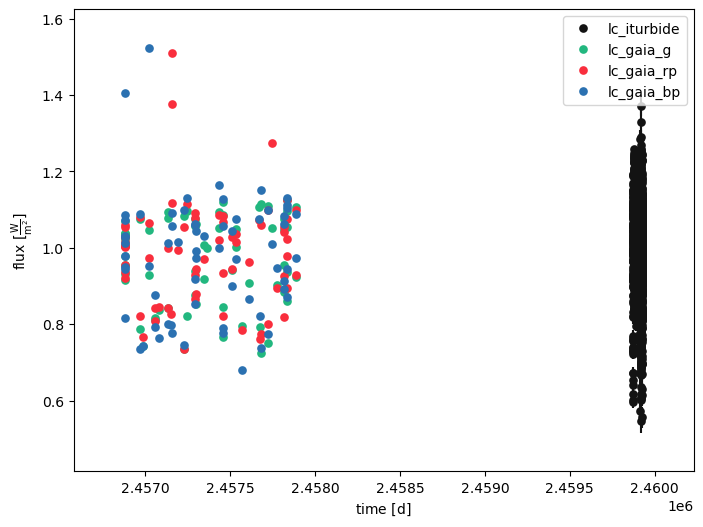

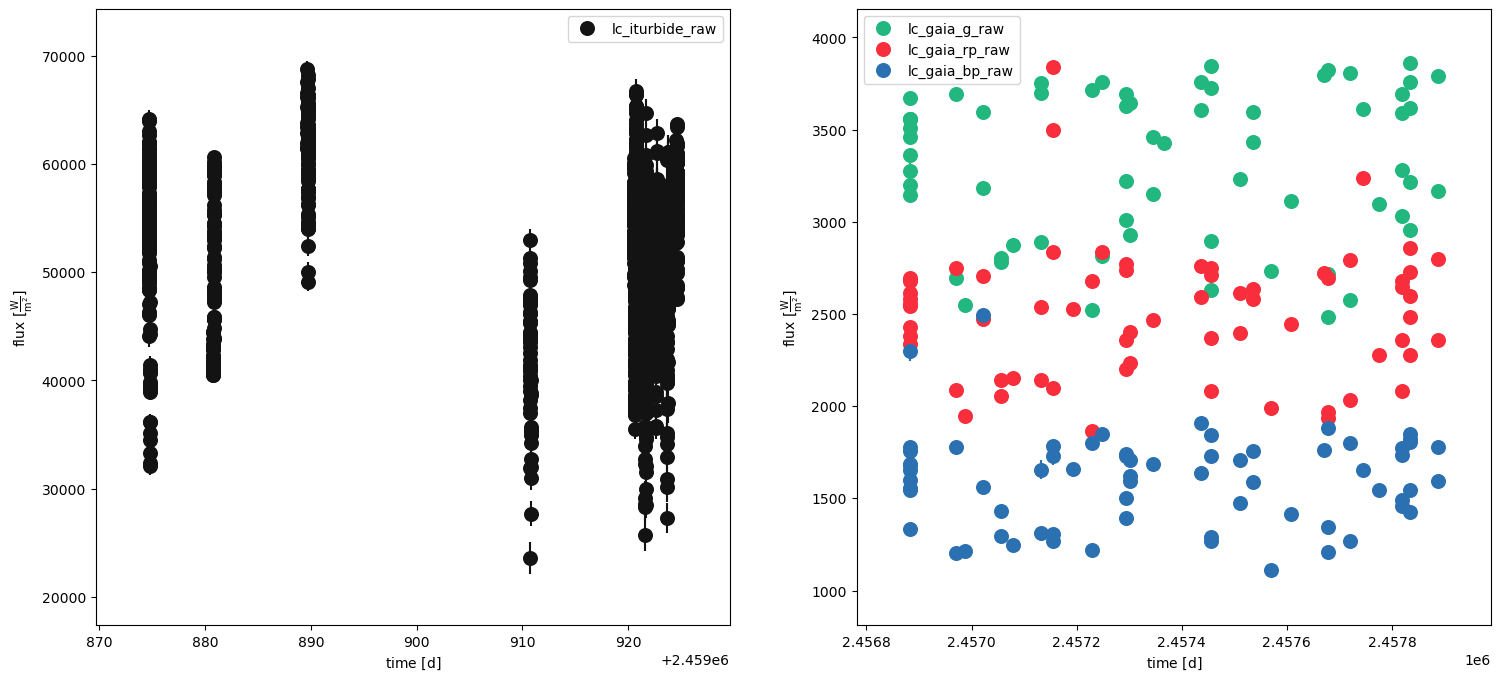

(<autofig.figure.Figure | 2 axes | 4 call(s)>,
 <Figure size 1800x800 with 2 Axes>)

In [2]:
# b = phoebe.load("../bundle-saves/iturbide_gaia-data")
# b = phoebe.load("../bundle-saves/aviles-data/iturbide_gaia-data")
b = phoebe.load("../bundle-saves/comp-LID-3/iturbide_gaia-data")
b.plot(kind='lc', dataset=[d for d in b.datasets if 'raw' not in d], show=True, legend=True, marker='.', color=gen_utils.GAIA_NORM_PLOT_COLORS)

fig = plt.figure(figsize=(18,8))
b.plot(dataset='lc_iturbide_raw', legend=True, marker='.', axorder=0, fig=fig)
b.plot(dataset=[d for d in b.datasets if 'gaia' in d and 'raw' in d], show=True, legend=True, marker='.', axorder=1, subplot_grid=(1,2), fig=fig, color=gen_utils.GAIA_RAW_PLOT_COLORS)

In [3]:
iturbideTimes = b.get_value(qualifier='times', dataset='lc_iturbide')

MIN_FREQ = 0.001 # avoiding zero
MAX_FREQ = (1 / (2*(60*u.second).to(u.day))).value # windowing limit windowed observations, taking delta-t = 60sec

N_0 = 9
GRID_SIZE = N_0 * (iturbideTimes[-1] - iturbideTimes[0]) * float(MAX_FREQ)
print(GRID_SIZE)

# setting a much finer grid for lower frequencies, since this is where we expect the orbital period to be
sub1 = phoebe.linspace(MIN_FREQ, 8, int(GRID_SIZE), endpoint=False)
# sub2 = phoebe.linspace(2, float(MAX_FREQ), int(GRID_SIZE) // 100)
# manualPeriodSample = np.concatenate([sub1, sub2])
manualPeriodSample = sub1

len(manualPeriodSample), manualPeriodSample[0], manualPeriodSample[-1]

323740.39671286946


(323740, 0.001, 7.999975291900908)

### Auto periodogram

ParameterSet: 10 parameters
R  period@lcperiod_iturbide_au...: [0.00131472 0.00134759
 0.00138045 ...
 0.91892188 0.91895475
 0.91898762] d
R  power@lcperiod_iturbide_aut...: [0.00199803 0.00244835
 0.00439658 ... 0.04773412
 0.04824466 0.04485063]
   period_factor@lcperiod_itur...: 1.0
R  fitted_twigs@lcperiod_iturb...: ['period@binary@orbit@component']
R  fitted_values@lcperiod_itur...: [0.07365705484822724]
R  fitted_units@lcperiod_iturb...: ['d']
   adopt_parameters@lcperiod_i...: ['period@binary@orbit@component']
   adopt_distributions@lcperio...: False
   adopt_values@lcperiod_iturb...: True
   comments@lcperiod_iturbide_...: 


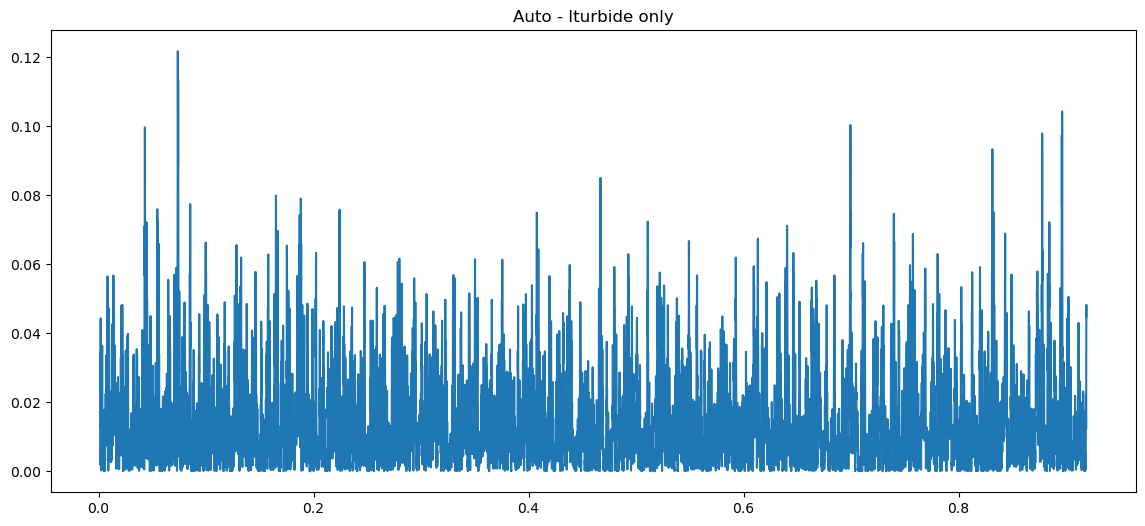

In [4]:
b.add_solver('estimator.lc_periodogram', solver='lcperiod_iturbide_auto', overwrite=True, algorithm='ls')
b.run_solver('lcperiod_iturbide_auto', solution='lcperiod_iturbide_auto_solution', overwrite=True)
print(b['lcperiod_iturbide_auto_solution'])

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(b.get_value('period@lcperiod_iturbide_auto_solution'), b.get_value('power@lcperiod_iturbide_auto_solution'))
ax.set_title("Auto - Iturbide only")
plt.show()

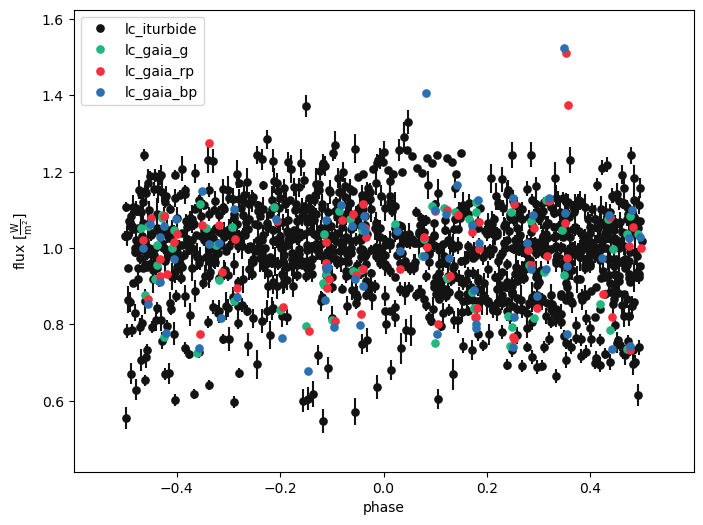

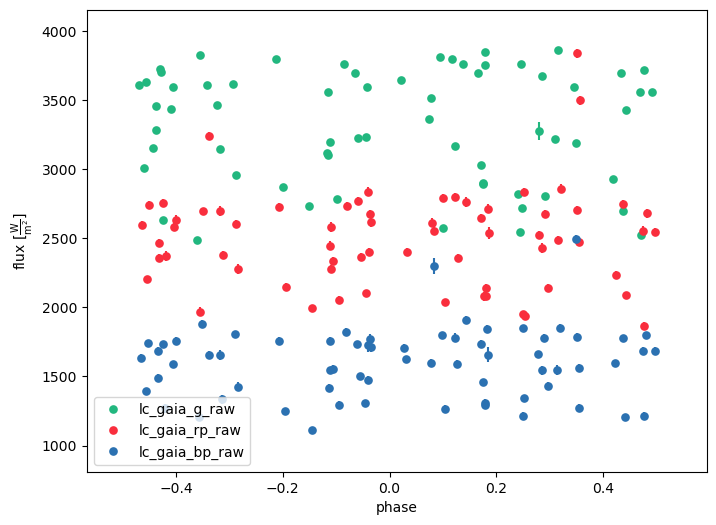

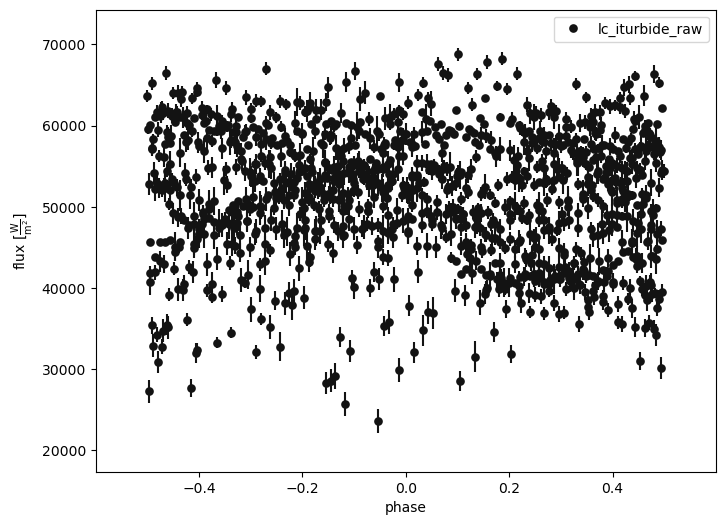

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [5]:
b.adopt_solution('lcperiod_iturbide_auto_solution', period_factor=1)
period = b.get_quantity(qualifier='period', component='binary')
# gen_utils.phasePlotEnabledData(b)
b.plot(x='phase', dataset=[d for d in b.datasets if 'raw' not in d], show=True, legend=True, marker='.', color=gen_utils.GAIA_NORM_PLOT_COLORS)
b.plot(x='phase', dataset=[d for d in b.datasets if 'raw' in d and 'gaia' in d], show=True, legend=True, marker='.', color=gen_utils.GAIA_RAW_PLOT_COLORS)
b.plot(x='phase', dataset='lc_iturbide_raw', show=True, legend=True, marker='.')

### Manual frequency grid

In [6]:
# avoid clutter when printing solver parameters for re-running periodogram (testing only)
if 'lcperiod_iturbide_manual_solution' in b.solutions:
    b.remove_solution('lcperiod_iturbide_manual_solution')

b.add_solver('estimator.lc_periodogram', solver='lcperiod_iturbide_manual', overwrite=True,
             algorithm='ls', sample_mode='manual',
            #  lc_datasets=['lc_iturbide'],
             sample_periods=manualPeriodSample)
print(b.filter(solver='lcperiod_iturbide_manual'))

ParameterSet: 8 parameters
   comments@lcperiod_iturbide_...: 
   use_server@lcperiod_iturbid...: none
   algorithm@lcperiod_iturbide...: ls
   lc_datasets@lcperiod_iturbi...: ['*']
   lc_combine@lcperiod_iturbid...: median
   component@lcperiod_iturbide...: binary
   sample_mode@lcperiod_iturbi...: manual
   sample_periods@lcperiod_itu...: [1.00000000e-03
 1.02470810e-03
 1.04941620e-03 ...
 7.99992588e+00
 7.99995058e+00
 7.99997529e+00] d


Parameter: t0@system
                       Qualifier: t0
                     Description: Time at which all values are provided.  For values with time-derivatives, this defines their zero-point.
                           Value: 0.0 d
                  Constrained by: 
                      Constrains: t0_perpass@binary@component, t0_ref@binary@component, mean_anom@binary@component
                      Related to: t0_supconj@binary@component, period@binary@component, ecc@binary@component, per0@binary@component, dpdt@binary@component, dperdt@binary@component, t0_perpass@binary@component, t0_ref@binary@component, mean_anom@binary@component

ParameterSet: 10 parameters
R  period@lcperiod_iturbide_ma...: [7.99997529e+00
 7.99995058e+00
 7.99992588e+00
 ...
 1.04941620e-03
 1.02470810e-03
 1.00000000e-03] d
R  power@lcperiod_iturbide_man...: [0.01663359
 0.0166299
 0.01662598
 ...
 0.01339829
 0.00238527
 0.00647064]
   period_factor@lcperiod_itur...: 1.0
R  fitted_twigs@lcperiod_iturb..

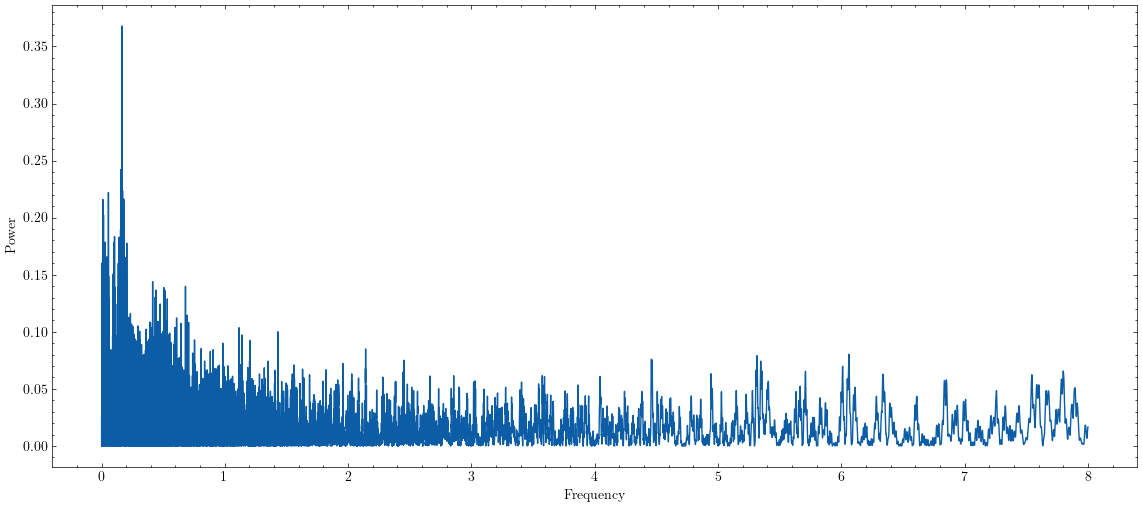

In [7]:
import scienceplots
plt.style.use("science")

b.run_solver('lcperiod_iturbide_manual', solution='lcperiod_iturbide_manual_solution', overwrite=True)
print(b['t0'])
print(b['lcperiod_iturbide_manual_solution'])

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(b.get_value('period@lcperiod_iturbide_manual_solution'), b.get_value('power@lcperiod_iturbide_manual_solution'))
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
plt.show()

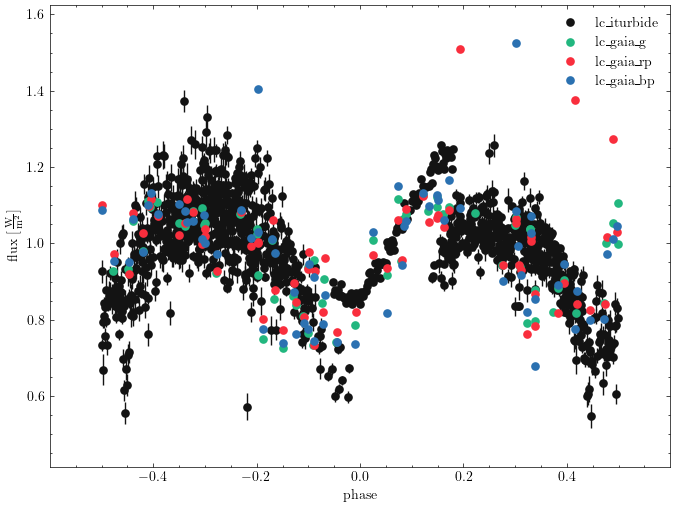

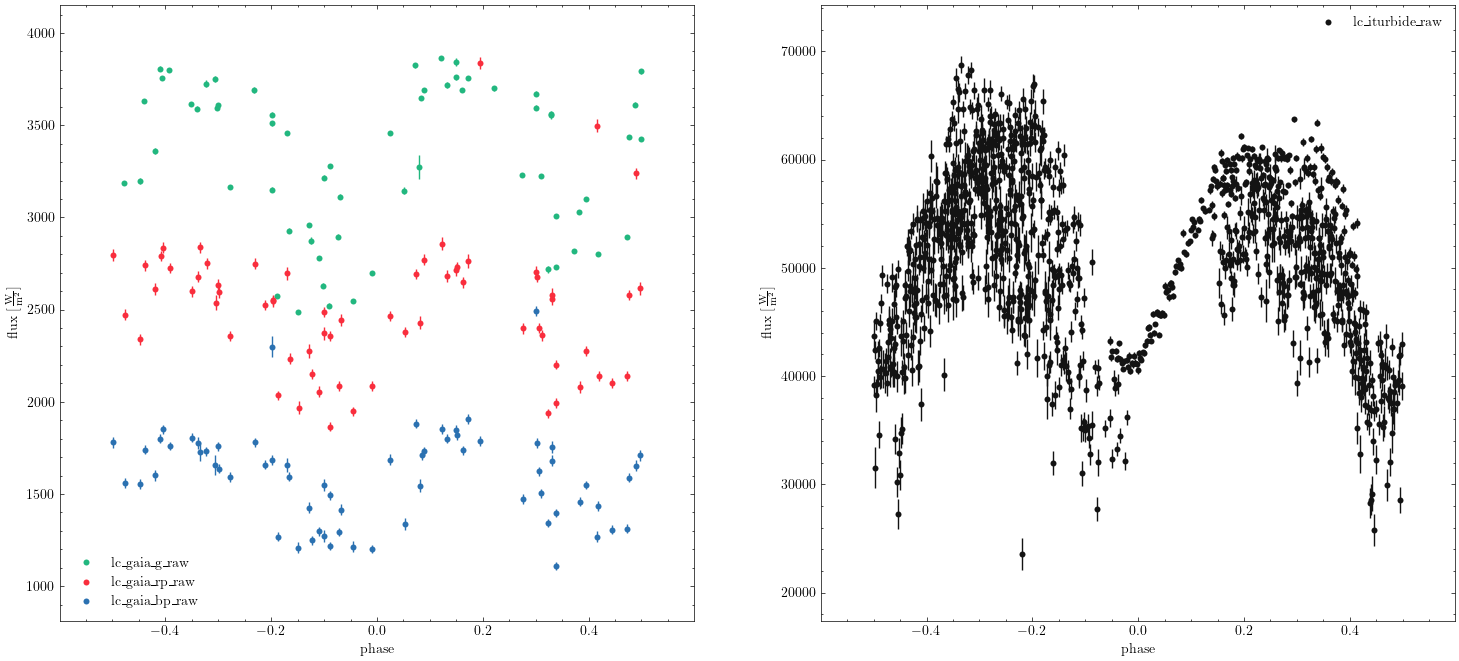

(<autofig.figure.Figure | 2 axes | 4 call(s)>,
 <Figure size 1800x800 with 2 Axes>)

In [8]:
b.adopt_solution('lcperiod_iturbide_manual_solution', period_factor=2)
period = b.get_quantity(qualifier='period', component='binary')

# b.plot(x='phase', dataset='lc_iturbide', show=True, legend=True, marker='.')
# b.plot(x='phase', dataset='lc_iturbide_raw', show=True, legend=True, marker='.')
b.plot(x='phase', dataset=[d for d in b.datasets if 'raw' not in d], show=True, legend=True, marker='.', color=gen_utils.GAIA_NORM_PLOT_COLORS)

fig = plt.figure(figsize=(18, 8))
b.plot(x='phase', dataset=['lc_gaia_g_raw', 'lc_gaia_rp_raw', 'lc_gaia_bp_raw'], legend=True, marker='.', color=gen_utils.GAIA_RAW_PLOT_COLORS, axorder=0, fig=fig, s=0.008)
b.plot(x='phase', dataset='lc_iturbide_raw', show=True, legend=True, marker='.', axorder=1, fig=fig, subplot_grid=(1,2), s=0.008)

In [9]:
print(b.get_quantity('period@binary', unit=u.hour))

8.005984555507505 h


In [10]:
# gen_utils.saveBundle(b, "manual-periodogram")
# gen_utils.saveBundle(b, "manual-periodogram", "aviles-data")
gen_utils.saveBundle(b, "manual-periodogram", "comp-LID3")

'bundle-saves/comp-LID3/manual-periodogram'